<a href="https://colab.research.google.com/github/Anirudh-R-1201/Shot_xG/blob/main/Shots_xG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from collections import OrderedDict
from imblearn.under_sampling import TomekLinks

%reload_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [107]:
from google.colab import files
files.upload()

Saving non_pen (1).csv to non_pen (1) (1).csv
Saving pens (1).csv to pens (1) (1).csv


{'non_pen (1).csv': b'id,duration,distance,build_up_duration,shot_technique_normal,shot_technique_lob,shot_technique_half_volley,shot_open_goal,pass_height_name,pass_cut_back,pass_through_ball,follows_goalkeeper,follows_dribble,pass_cross,goal,player_name,team_name,match_id,x_loc,y_loc,pass_player_name\n29cec991-ba6a-47d6-b793-045461abdaf7,1.388,16.114899937635354,10.704,1,0,0,0,-1,0,0,0,0,0,1,Cristian Portugu\xc3\xa9s Manzanera,Girona,9811,111.2,26.5,\n4a9dc002-2667-47b1-b667-8c45d2b0f529,2.356,31.918803235710453,0.0,1,0,0,0,-1,0,0,0,0,0,0,Luis Alberto Su\xc3\xa1rez D\xc3\xadaz,Barcelona,9592,90.0,29.1,\n55a668d4-355d-4fa2-b5c8-6efc0f1065c3,0.047,23.96539171388609,10.280399999999998,1,0,0,0,-1,0,0,0,0,0,0,Toni Kroos,Real Madrid,16196,96.5,44.7,\n66af161f-af2a-4879-9302-5f8d81c1df3b,0.1505,8.59069263796581,56.206250999999995,1,0,0,0,-1,0,0,0,0,0,0,Pedro Eliezer Rodr\xc3\xadguez Ledesma,Barcelona,267197,112.2,36.4,\n78e3d880-f3c2-4682-9a97-4cd5ce5daeab,0.953572,30.008332176247308,0.0,1,

In [69]:
data = pd.read_csv('data.csv', index_col=0)
X = data.drop('goal', axis=1)
y = data['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y, random_state=42)

In [70]:
def plot_loss(model_list, min_estimators=10, max_estimators=200):
    loss_rate = OrderedDict((clf_name, []) for clf_name, _ in model_list)

    min_estimators = min_estimators
    max_estimators = max_estimators

    for clf_name, clf in model_list:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)
            brier = brier_score_loss(y_test, y_pred_proba[:,1])
            loss_rate[clf_name].append((i, brier))
    
    plt.figure(figsize=(12,8))
    
    for clf_name, clf_err in loss_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=clf_name)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("Brier loss")
    plt.legend(loc="upper right");
    return

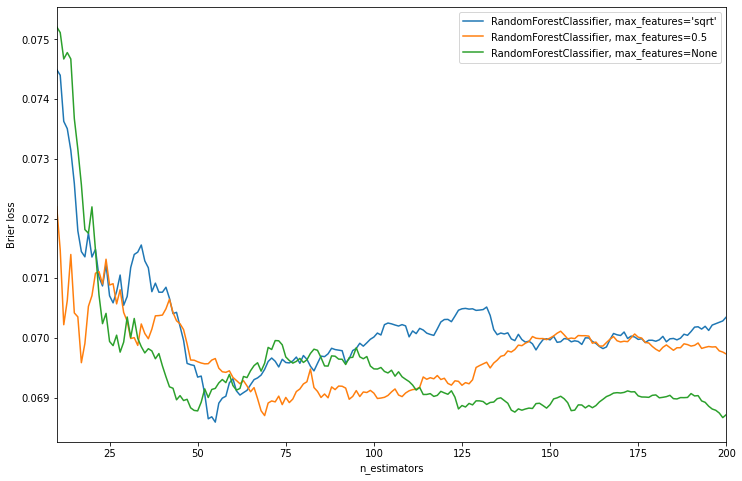

In [71]:
max_features = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features='sqrt', random_state=42)),
    ("RandomForestClassifier, max_features=0.5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=0.5, random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=None, random_state=42)),
]

plot_loss(max_features)

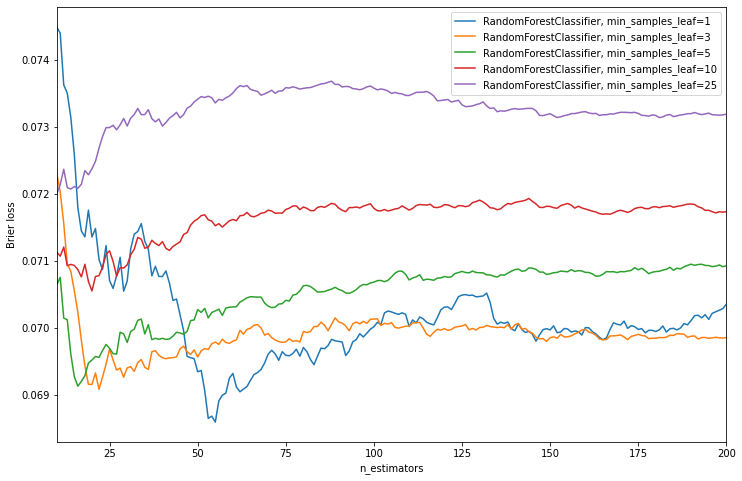

In [72]:
min_leaf = [
    ("RandomForestClassifier, min_samples_leaf=1",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=1, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=3, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=5, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=10",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=10, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=25",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=25, random_state=42)),
]

plot_loss(min_leaf)

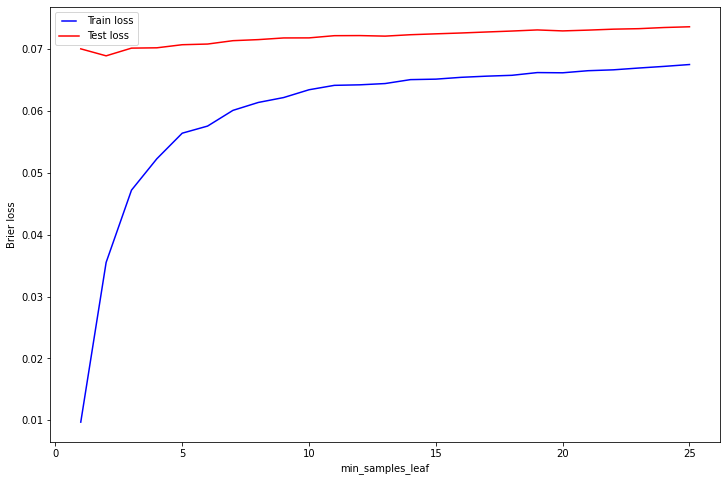

In [73]:
min_leaf = [int(x) for x in np.linspace(start=1, stop=25, num=25)]
train_results = []
test_results = []
for leaf in min_leaf:
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=leaf, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(min_leaf, train_results, 'b', label='Train loss')
line2, = plt.plot(min_leaf, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('min_samples_leaf');

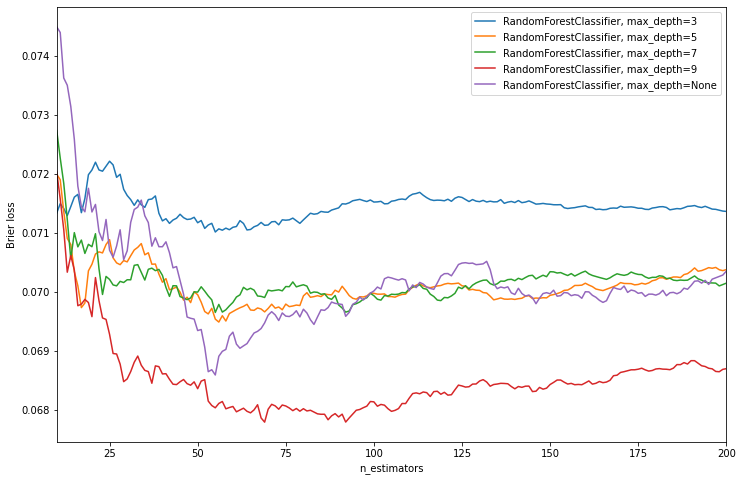

In [74]:
max_depth = [
    ("RandomForestClassifier, max_depth=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=3, random_state=42)),
    ("RandomForestClassifier, max_depth=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=5, random_state=42)),
    ("RandomForestClassifier, max_depth=7",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=7, random_state=42)),
    ("RandomForestClassifier, max_depth=9",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=9, random_state=42)),
    ("RandomForestClassifier, max_depth=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=None, random_state=42)),
]

plot_loss(max_depth)

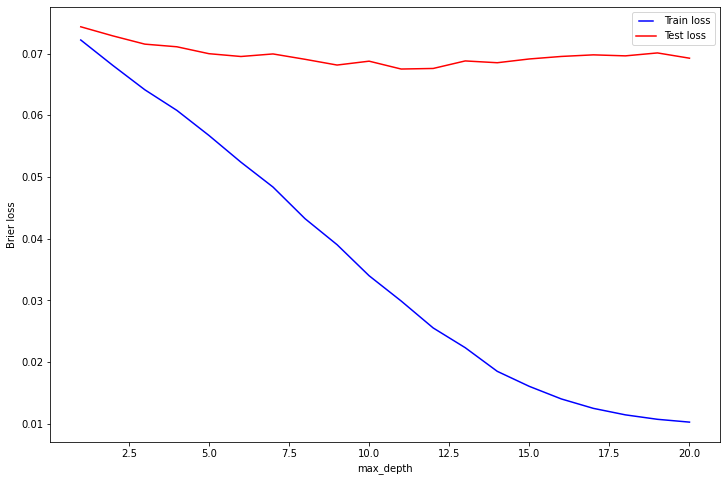

In [75]:
max_depths = np.linspace(1, 20, 20, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(max_depths, train_results, 'b', label='Train loss')
line2, = plt.plot(max_depths, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('max_depth');

In [76]:
m = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='sqrt', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.06647


In [77]:
params = {
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'max_depth': [7, 8, 9, 10, 11]
}

gs = GridSearchCV(estimator=m, param_grid=params, cv=cv, n_jobs=-1,
                  scoring='brier_score_loss', return_train_score=True)

gs.fit(X_train, y_train)

def print_gs_results(gs, print_all=True):
    if print_all == True:
        print('Grid scores:')
        means = gs.cv_results_['mean_test_score']*-1
        stds = gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean, std * 2, params))
        print()
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    else:
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    return

print_gs_results(gs=gs)

Grid scores:
0.06672 (+/-0.00700) for {'max_depth': 7, 'min_samples_leaf': 3}
0.06700 (+/-0.00633) for {'max_depth': 7, 'min_samples_leaf': 4}
0.06753 (+/-0.00609) for {'max_depth': 7, 'min_samples_leaf': 5}
0.06802 (+/-0.00583) for {'max_depth': 7, 'min_samples_leaf': 6}
0.06861 (+/-0.00577) for {'max_depth': 7, 'min_samples_leaf': 7}
0.06645 (+/-0.00748) for {'max_depth': 8, 'min_samples_leaf': 3}
0.06673 (+/-0.00683) for {'max_depth': 8, 'min_samples_leaf': 4}
0.06746 (+/-0.00572) for {'max_depth': 8, 'min_samples_leaf': 5}
0.06759 (+/-0.00607) for {'max_depth': 8, 'min_samples_leaf': 6}
0.06846 (+/-0.00615) for {'max_depth': 8, 'min_samples_leaf': 7}
0.06628 (+/-0.00749) for {'max_depth': 9, 'min_samples_leaf': 3}
0.06685 (+/-0.00692) for {'max_depth': 9, 'min_samples_leaf': 4}
0.06747 (+/-0.00589) for {'max_depth': 9, 'min_samples_leaf': 5}
0.06778 (+/-0.00602) for {'max_depth': 9, 'min_samples_leaf': 6}
0.06838 (+/-0.00579) for {'max_depth': 9, 'min_samples_leaf': 7}
0.06601 (+/-

In [78]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.06768


In [79]:
print(xgb.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


In [80]:
params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.4],
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=9)],
    'max_depth': [i for i in range(3, 10)],
    'min_child_weight': [i for i in range(1, 7)],
    'subsample': [i/10.0 for i in range(6,11)],
    'colsample_bytree': [i/10.0 for i in range(6,11)]
}
rgs = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=20, cv=cv, random_state=42, n_jobs=-1,
                         scoring='brier_score_loss', return_train_score=True)

rgs.fit(X_train, y_train)

print_gs_results(gs=rgs, print_all=False)

Best: 0.06732 using {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


In [81]:
def print_results(rf, xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):

    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

    print('Actual goals:', sum(y_test))
    print('Predicted goals (rf):', '{0:.2f}'.format(sum(y_pred_proba_rf)))
    print('Predicted goals (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (rf):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_rf)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))
    return

best_rf = gs.best_estimator_
best_xgb = rgs.best_estimator_

print_results(rf=best_rf, xgb=best_xgb)

Actual goals: 42
Predicted goals (rf): 39.15
Predicted goals (xgb): 38.70
Brier loss (rf): 0.06987
Brier loss (xgb): 0.07160


In [82]:
calibrated_rf = CalibratedClassifierCV(gs.best_estimator_, cv=cv, method='sigmoid')
calibrated_xgb = CalibratedClassifierCV(rgs.best_estimator_, cv=cv, method='sigmoid')

print_results(rf=calibrated_rf, xgb=calibrated_xgb)

Actual goals: 42
Predicted goals (rf): 38.63
Predicted goals (xgb): 37.90
Brier loss (rf): 0.07117
Brier loss (xgb): 0.07268


In [83]:
tomek = TomekLinks(n_jobs=-1, random_state=42)
X_train_res, y_train_res = tomek.fit_resample(X_train, y_train)

print('UNCALIBRATED')
print_results(rf=best_rf, xgb=best_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)
print('\nCALIBRATED')
print_results(rf=calibrated_rf, xgb=calibrated_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)

UNCALIBRATED


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Actual goals: 42
Predicted goals (rf): 40.98
Predicted goals (xgb): 41.64
Brier loss (rf): 0.06925
Brier loss (xgb): 0.07064

CALIBRATED
Actual goals: 42
Predicted goals (rf): 39.34
Predicted goals (xgb): 40.01
Brier loss (rf): 0.07183
Brier loss (xgb): 0.07197


Model Trained over World Cup 2018 data from Statsbomb

In [84]:
import pickle
filename = 'final_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))

files.download('final_model.sav')
model = pickle.load(open(filename, 'rb'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
non_pen = pd.read_csv('non_pen (1) (1).csv', index_col=0)
pens = pd.read_csv('pens (1) (1).csv', index_col=0)

X_new = non_pen.drop('goal', axis=1)
y_new = non_pen['goal']

extra_cols = ['player_name', 'team_name', 'match_id', 'x_loc', 'y_loc', 'pass_player_name']
extras = X_new[extra_cols]
X_new= X_new.drop(extra_cols, axis=1)

model.fit(X_new, y_new)

xg_df = X_new.copy()
xg_df['goal'] = y_new
xg_df['xg'] = model.predict_proba(X_new)[:,1]
xg_df['xa'] = np.where(xg_df['xg'].isna(), 0, xg_df['xg'])
xg_df = xg_df.merge(extras, left_index=True, right_index=True)
xg_df = xg_df.append(pens, sort=True)

xg_df['x_loc_m'] = xg_df['x_loc'] / 120 * 104
xg_df['y_loc_m'] = xg_df['y_loc'] / 80 * 68

In [109]:
# See http://petermckeever.com/plotting-xy-football-data-in-python/
def draw_pitch(pitch, line, orientation, view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(69,105)
            plt.ylim(-1,69)
            # final third line
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(69,105)
            plt.xlim(-1,69)
            # final third line
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        return

In [110]:
xg_df['team_name'].unique()

array(['Girona', 'Barcelona', 'Real Madrid', 'Real Valladolid', 'Granada',
       'Espanyol', 'Leganés', 'Rayo Vallecano', 'Athletic Bilbao',
       'Real Sociedad', 'Celta Vigo', 'Eibar', 'Getafe', 'Villarreal',
       'Valencia', 'Deportivo La Coruna', 'Las Palmas', 'Sevilla',
       'Levante', 'Atlético Madrid', 'Real Betis', 'Málaga',
       'Deportivo Alavés', 'Huesca', 'Osasuna', 'Almería', 'Córdoba',
       'Elche'], dtype=object)

In [112]:
temp = xg_df[xg_df['team_name'] == 'Barcelona']
temp['player_name'].unique()

array(['Luis Alberto Suárez Díaz', 'Pedro Eliezer Rodríguez Ledesma',
       'Lionel Andrés Messi Cuccittini', 'Andrés Iniesta Luján',
       'Ivan Rakitić', 'Gerard Piqué Bernabéu',
       'Sergio Busquets i Burgos', 'Daniel Alves da Silva',
       'Arthur Henrique Ramos de Oliveira Melo',
       'Alexis Alejandro Sánchez Sánchez', 'Philippe Coutinho Correia',
       'Xavier Hernández Creus', 'Neymar da Silva Santos Junior',
       'Francesc Fàbregas i Soler', 'José Paulo Bezzera Maciel Júnior',
       'Thomas Vermaelen', 'Jordi Alba Ramos', 'Carles Aleña Castillo',
       'André Filipe Tavares Gomes', 'Martín Montoya Torralbo',
       'Francisco Alcácer García', 'Malcom Filipe Silva de Oliveira',
       'Arturo Erasmo Vidal Pardo', 'Adriano Correia Claro',
       'Nélson Cabral Semedo', 'Rafael Alcântara do Nascimento',
       'Ousmane Dembélé', 'Denis Suárez Fernández',
       'Sergi Roberto Carnicer', 'Munir El Haddadi Mohamed',
       'Jérémy Mathieu', 'Clément Lenglet', 'Javier A

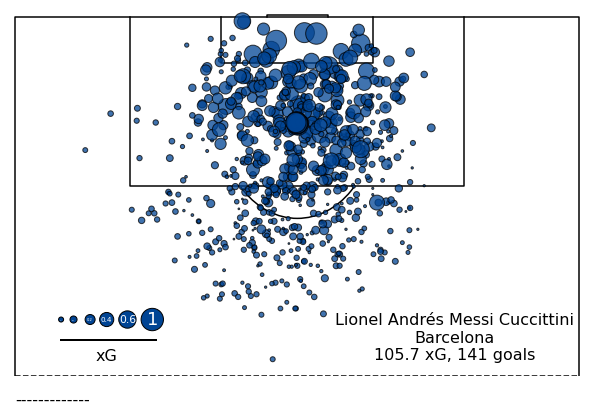

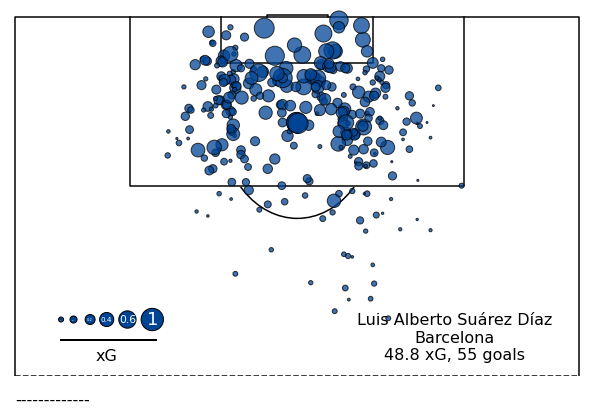

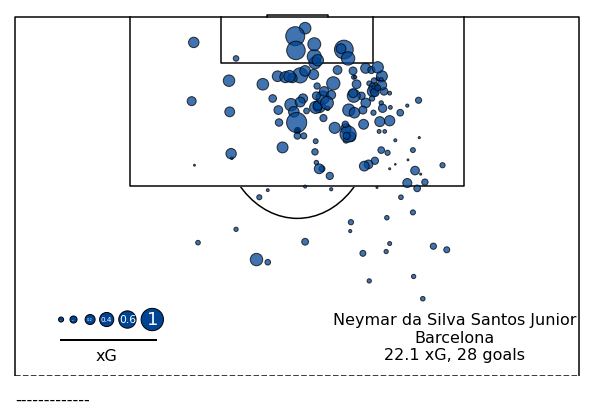

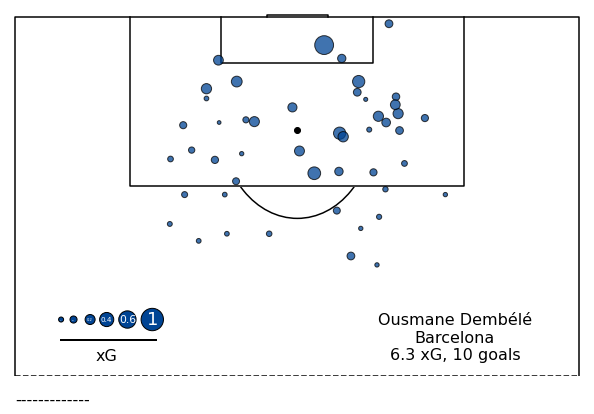

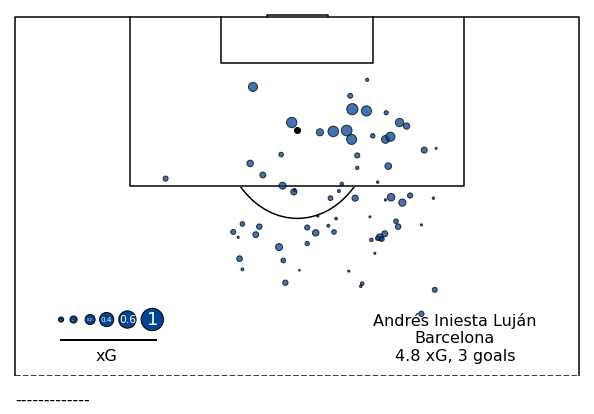

In [115]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def xg_plot(df, team_name, player_name=None, pitch_colour='#ffffff', line_colour='#000000', marker_colour='default'):
    
    # Draw pitch first
    draw_pitch(pitch_colour, line_colour, orientation='vertical', view='third')

    # Filter df 
    if player_name is not None:
        df = df[df['player_name'] == player_name]
        df = df[df['team_name'] == team_name]
    else:
        player_name=''
        df = df[df['team_name'] == team_name]
        
    markers = {
                'Barcelona':'#004494', 'Sevilla':'#561416', 'France':'#1A284B', 'Russia': '#F00000', 'Senegal':'#C0F76D', 'Sweden':'#B02534',
                'Real Madrid':'#004494', 'Costa Rica':'#1A284B', 'Egypt':'#7D2B3A', 'Liverpool': '#E31B23', 'Colombia':'#B02534',
                'Argentina': '#001489', 'Portugal':'#11437E', 'Atlético Madrid':'#E03F28', 'Denmark':'#561416', 'Iran':'#7D2B3A', 'Poland':'#11437E',
                'Mexico': '#561416', 'South Korea':'#41B6E6', 'Japan':'#41B6E6', 'Belgium':'#C0F76D', 'Iceland':'#022B52', 'Tunisia':'#7D2B3A',
                'Germany':'#00653B', 'Nigeria': '#561416', 'Spain': '#F00000', 'Uruguay':'#022B52', 'Switzerland':'#11437E',
                'Australia':'#00653B', 'Serbia':'#41B6E6', 'Panama':'#00653B', 'Morocco': '#F00000', 'England':'#0054A6',
                'Saudi Arabia': '#561416'
              }
    
    if marker_colour == 'default':
        marker_colour = markers.get(team_name)
    else: pass
    x_loc = df['x_loc_m']
    y_loc = [68 - i for i in df['y_loc_m']] 
    xg = [500 * i for i in df['xg']]
    
    zo = 12 
    
    plt.scatter(y_loc, x_loc, s=xg, c=marker_colour, edgecolors='k', zorder=zo, alpha=0.75)

    mSize = [0.05,0.10,0.2,0.4,0.6,1] 
    mSizeS = [500 * i for i in mSize]
    mx = [5.5,7,9,11,13.5,16.5]
    my = [74.5,74.5,74.5,74.5,74.5,74.5]
    plt.scatter(mx, my, s=mSizeS, facecolors=marker_colour, edgecolor='k', zorder=zo)
    plt.plot([5.5,17], [72.5,72.5], color=line_colour, lw=2, zorder=zo)
    i = 0
    for i in range(len(mx)):
        plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color=pitch_colour, zorder=zo, ha='center', va='center')
    plt.text(11, 71,'xG', color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)

    xg_sum = str(round(np.sum(df['xg']), 1))
    goal_sum = str(np.sum(df['goal']))
    legend_string = player_name + '\n' + team_name + '\n' + xg_sum + ' xG, ' + goal_sum + ' goals'
    plt.text(53, 72.75, legend_string, color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)
    
    info_string = '-------------'
    plt.text(0, 66, info_string, color=line_colour, ha='left', va='bottom', zorder=zo, fontsize=16);
    return




#xg_plot(df=xg_df, team_name='Real Madrid', player_name='Cristiano Ronaldo dos Santos Aveiro')
xg_plot(df=xg_df, team_name='Barcelona', player_name='Lionel Andrés Messi Cuccittini')
xg_plot(df=xg_df, team_name='Barcelona', player_name='Luis Alberto Suárez Díaz')
xg_plot(df=xg_df, team_name='Barcelona', player_name='Neymar da Silva Santos Junior')
xg_plot(df=xg_df, team_name='Barcelona', player_name='Ousmane Dembélé')
xg_plot(df=xg_df, team_name='Barcelona', player_name='Andrés Iniesta Luján')